# Analyze One Trained Model

In [1]:
import pandas as pd
import os.path
import subprocess
import json
import os
import h5py
import numpy as np
import tqdm
from tqdm import tqdm_notebook
import itertools
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox, TextArea
from matplotlib.colors import LogNorm, Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.cm import ScalarMappable

import seaborn as sb

from analysis import load_model


Training on cuda


# Load trained model

In [2]:
run = "test0"
model_dir = os.getcwd()+'/'+f"models/{run}/"
fig_dir = model_dir+"figs/"

In [3]:
# load model metadata
f = open(f"{model_dir}model.json")
metadata = json.load(f)
model_metada = metadata["model"]

In [4]:
# load on model
model, state = load_model(model_dir, model_metada)

In [5]:
print(state.keys())

dict_keys(['model_state_dict', 'optimizer_state_dict', 'train_losses', 'test_losses', 'epochs', 'last_epoch'])


# Plot training history

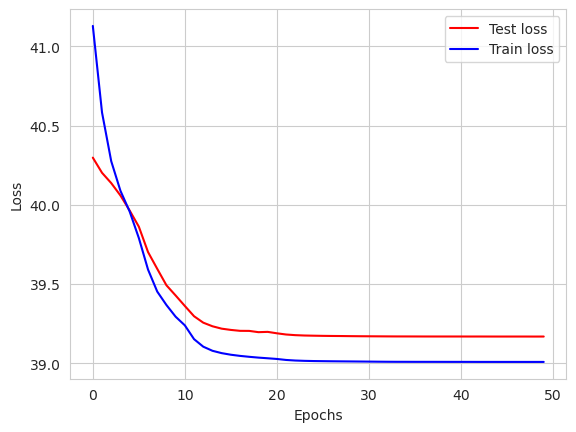

In [6]:
# Plot train/test loss function as a function of time
df_train = pd.DataFrame.from_dict(state["train_losses"])
df_test = pd.DataFrame.from_dict(state["test_losses"])
fig, ax = plt.subplots(ncols=1,nrows=1)
ax.plot(range(df_test.shape[0]),df_test['Loss'].ewm(span=3, adjust=False).mean(),color="red",label="Test loss")
ax.plot(range(df_train.shape[0]),df_train['Loss'].ewm(span=3, adjust=False).mean(),color="blue",label="Train loss")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
# ax.set_title(fname.split('/')[-1])
ax.legend(loc="best")

# Visualize Latent Space

t-SNE (contrary to PCA) is a nonlinear technique that focuses on preserving the pairwise similarities 
between data points in a lower-dimensional space. 
t-SNE is concerned with preserving small pairwise distances whereas, 
PCA focuses on maintaining large pairwise distances to maximize variance.
Thus, PCA preserves the variance in the data, whereas t-SNE preserves the relationships 
between data points in a lower-dimensional space, making it quite a good algorithm for visualizing complex high-dimensional data. 

In [8]:
# Plot 3 columns for Xhat, Mu, LogVar for all features (2D using t-SNE)
def plot_latent_space_for_epoch(xhat_,mu_,logvar_,phys_,figname,title=None,show=False):
    # unpack
    x_xhat, y_yhat = xhat_[:, 0], xhat_[:, 1]
    x_mu, y_mu = mu_[:, 0], mu_[:, 1]
    x_logvar, y_logvar = logvar_[:, 0], logvar_[:, 1]

    # plot
    cmap_name = "coolwarm_r" # 'coolwarm_r'
    fig, axes = plt.subplots(ncols=3,nrows=len(features_names),figsize=(8,12))
    
    if not title is None:
        fig.suptitle(title, fontsize=15)

    axes[0, 0].set_title(r"$\hat{X}$",fontsize=12)
    axes[0, 1].set_title(r"$\mu$",fontsize=12)
    axes[0, 2].set_title(r"$\log(\sigma^2)$",fontsize=12)
    for i, f in enumerate(features_names):
        # print(np.min(phys_[:,i]),', ', np.max(phys_[:,i]))
        if (np.min(phys_[:,i])<=0
                or (np.max(phys_[:, i])/np.min(phys_[:, i])<10)):
            norm = Normalize(vmin=np.min(phys_[:, i]),
                             vmax=np.max(phys_[:, i]))
        else:
            norm = LogNorm(vmin=np.min(phys_[:,i]),
                           vmax=np.max(phys_[:,i]))

        cmap = plt.get_cmap(cmap_name)

        colors = cmap(norm(phys_[:,i]))
        # labels_collated[:,i]

        im = axes[i,0].scatter(x_xhat, y_yhat, marker='.', s=20, c=colors, alpha=.6)
        im = axes[i,1].scatter(x_mu, y_mu, marker='.', s=20, c=colors, alpha=.6)
        im = axes[i,2].scatter(x_logvar, y_logvar, marker='.', s=20, c=colors, alpha=.6)

        divider = make_axes_locatable(axes[i,2])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        cbar = fig.colorbar(ScalarMappable(norm=norm, cmap=cmap),
                            cax=cax, orientation='vertical', label=features_names[i])
        cbar.ax.tick_params(labelsize=10)
        
        for ax in axes[i,:]:
            # Hide X and Y axes label marks
            ax.xaxis.set_tick_params(labelbottom=False)
            ax.yaxis.set_tick_params(labelleft=False)

            # Hide X and Y axes tick marks
            ax.set_xticks([])
            ax.set_yticks([])

            ax.patch.set_visible(False)
            ax.axis('off')

    # plt.scatter(x, y, marker='.', s=20, c=labels_collated[:,5], cmap='coolwarm_r', alpha=.7)
    # plt.colorbar(label=features_names[5])

    # plt.xlabel('embedding 1')
    # plt.ylabel('embedding 2')
    # plt.legend(loc='best', fontsize='x-large')
    plt.tight_layout()
    plt.savefig(figname,dpi=256)
    print(f"\tsaving...{figname}")
    if show:
        plt.show()
    else:
        plt.close(fig)

    # 
    # 
    # 
    # mode='imgs'
    # fig, ax = plt.subplots(figsize=(10, 7))
    # ax.set_title(f't-SNE for {epoch}')
    # if mode == 'imgs':
    #     for image, (x, y) in zip(data_collated.cpu(), xhat_tsne):
    #         im = OffsetImage(image.reshape(28, 28), zoom=1, cmap='gray')
    #         ab = AnnotationBbox(im, (x, y), xycoords='data', frameon=False)
    #         ax.add_artist(ab)
    #     ax.update_datalim(xhat_tsne)
    #     ax.autoscale()
    # elif mode == 'dots':
    #     classes = labels_collated
    #     plt.scatter(xhat_tsne[:, 0], xhat_tsne[:, 1])
    #     # plt.colorbar()
    #     # for i in range(10):
    #     #     class_center = np.mean(coords[classes == i], axis=0)
    #     #     text = TextArea('{}'.format(i))
    #     #     ab = AnnotationBbox(text, class_center, xycoords='data', frameon=True)
    #     #     ax.add_artist(ab)
    # # plt.show()
    # plt.savefig(figdir+f"latent_{epoch}.png")

# load latent sapce
dimensity_reduction_method = "t-SNE"

# init file where to store reduced latent sapce
fname_latent = model_dir+f"latent_{dimensity_reduction_method}.h5"
if not os.path.isfile(fname_latent):
    print(f"File not found: {fname_latent}")
    raise FileNotFoundError(f"File not found: {fname_latent}")

# df_train = pd.read_csv(fname.replace(".pt","_train_losses.csv"))
# df_test = pd.read_csv(fname.replace(".pt","_test_losses.csv"))

with h5py.File(fname_latent,"r") as f:
    epochs = int(f.attrs["epochs"])
    features_names = list([str(val.decode("utf-8")) for val in f["features_names"]])
    for e in range(epochs): # [epochs-1]:#range(epochs):
        group = f[f"epoch={e}"]
        plot_latent_space_for_epoch(
            xhat_ =np.array(group["xhat"]),
            mu_ =np.array(group["mu"]),
            logvar_ =np.array(group["logvar"]),
            phys_ =np.array(group["phys_labels"]),
            figname =fig_dir+"latent_"+str(e).zfill(3)+".png",
            title=f"E={e}/{epochs-1}| tLoss={df_test['Loss'][e]:.2f} | {dimensity_reduction_method}",
            show=False
        )
print("Latent space for all epochs plotted")

	saving.../home/vsevolod/Work/GIT/GitHub/PBA_projects/ml_lightcurve/models/test0/figs/latent_000.png
	saving.../home/vsevolod/Work/GIT/GitHub/PBA_projects/ml_lightcurve/models/test0/figs/latent_001.png
	saving.../home/vsevolod/Work/GIT/GitHub/PBA_projects/ml_lightcurve/models/test0/figs/latent_002.png
	saving.../home/vsevolod/Work/GIT/GitHub/PBA_projects/ml_lightcurve/models/test0/figs/latent_003.png
	saving.../home/vsevolod/Work/GIT/GitHub/PBA_projects/ml_lightcurve/models/test0/figs/latent_004.png
	saving.../home/vsevolod/Work/GIT/GitHub/PBA_projects/ml_lightcurve/models/test0/figs/latent_005.png
	saving.../home/vsevolod/Work/GIT/GitHub/PBA_projects/ml_lightcurve/models/test0/figs/latent_006.png
	saving.../home/vsevolod/Work/GIT/GitHub/PBA_projects/ml_lightcurve/models/test0/figs/latent_007.png
	saving.../home/vsevolod/Work/GIT/GitHub/PBA_projects/ml_lightcurve/models/test0/figs/latent_008.png
	saving.../home/vsevolod/Work/GIT/GitHub/PBA_projects/ml_lightcurve/models/test0/figs/laten

In [ ]:
# combine images into a movie
figdir = model_dir+"figs/"
subprocess.run([f"ffmpeg -framerate 4 -i {figdir}*.png -c:v libx264 -profile:v high -crf 30 -pix_fmt yuv420p -vf 'minterpolate=fps=60:mi_mode=mci:mc_mode=aobmc:me_mode=bidir:vsbmc=1' {figdir}out2.mp4"])